# Mini-tutorial: Wikidata + sheXer

sheXer is a python library. It's an open source project available in github: [https://github.com/DaniFdezAlvarez/shexer/](https://github.com/DaniFdezAlvarez/shexer/). 

You can install it using pip.

In [1]:
!pip install shexer

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 482 kB 20.8 MB/s 
     |████████████████████████████████| 41 kB 482 kB/s 
  Created wheel for shexer: filename=shexer-2.0.0-py3-none-any.whl size=134892 sha256=ef3513827a10b4b05e245206316ebca514ed9b075b4298bddddf221f06af054e
  Stored in directory: /root/.cache/pip/wheels/d4/37/7d/f40cfbd191f7560822865de3a548cc9f1817b447c47f76aaef
  Created wheel for wlighter: filename=wlighter-1.0.1-py3-none-any.whl size=5858 sha256=833f1076790781c8f8caf85455c756e168675953acc75744561289d5b46bf5b6
  Stored in directory: /root/.cache/pip/wheels/1e/6b/bb/a395004064bde6fb7bd62c4a3406c9da3b529c1c1c4fb26500
Successfully built shexer wlighter


sheXer is highly parametrizable, but it works in a pretty straightforward way. First, you need to import the class Shaper:

In [2]:
from shexer.shaper import Shaper

/usr/local/lib/python3.7/dist-packages/rdflib_jsonld/__init__.py:12: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.1.  Please remove rdflib-jsonld from your project's dependencies.
  DeprecationWarning,


Then, you need to create a Shaper object using some of its __init__ parameters.

Those parameters are documented in the [sheXer's repository](https://github.com/DaniFdezAlvarez/shexer/#the-class-shaper). To begin with, you must consider three main questions:


1.   How do you want to provide the input?
2.   What shapes do you want to extract?
3.   How do you want to obtain the output?

Let's start getting a shape for a COVID-19 treatment: [dexamethasone](https://www.wikidata.org/wiki/Q422252)



In [3]:
# Random example with a Q
shape_map_raw = "<http://www.wikidata.org/entity/Q422252>@<SomeTreatment>"

shaper = Shaper(shape_map_raw=shape_map_raw,
                url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31")

Once the __Shaper__ object is built, you can extract shapes by calling *shaper.shex_graph()*. This function has also several parameters to configure the output. For now, let's just use a flag to obtain the result as a raw string ( you may want to get the result written in a local file instead).

In [ ]:
str_result = shaper.shex_graph(string_output=True)
print(str_result)

Et violà! You've extracted you first shape. But there is a lot of room for improvement here to make these results useful and readable.

First of all, the common situation is that you do not want to extract a shape for a single entity, but for a group of them. In case you want to get a shape for every instance of a class, you can use the parameter *target_classes*, which expects a list of class URIs.

sheXer will get every instance of a target class and explore their neighborhood to create a shape. Let's try with the class [RNA vaccine](wd:Q85795487) with a few instances in Wikidata:

In [ ]:
shaper = Shaper(url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31",
                target_classes=["http://www.wikidata.org/entity/Q85795487"])
str_result = shaper.shex_graph(string_output=True)
print(str_result)

As you can see, these results include some percentages. For a given constraint, these percentages indicate the ratio of entities used to build a shape that actually conform with that constraint. 

By default,sheXer include a constraint for every feature observed in any entity. However, one may want to get shapes with features of a higher conformance ratio. You can use the parameter *acceptance_threshold* in *shex_graph()* to do so.

Let's say that we want to extract constraints that are supported by, at least, 50% of the entities.

In [ ]:
shaper = Shaper(url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31",
                target_classes=["http://www.wikidata.org/entity/Q85795487"])
str_result = shaper.shex_graph(string_output=True,
                               acceptance_threshold=0.5)
print(str_result)

As you can see, may constraints have dissapeared, both from the actual shapes and the comments. 

In case you want to get a shape for a custom group of individuals, you can use shape maps. Let's get a shape for COVID treatments. You can select those individuals using [a SPARQL query](https://w.wiki/4eXa) and then linking that query to a shape label:

In [ ]:
shape_map_raw = 'SPARQL "select ?s where { ?s <http://www.wikidata.org/prop/direct/P31> <http://www.wikidata.org/entity/Q85795487> }"@<CovidTreatments>'

shaper = Shaper(shape_map_raw=shape_map_raw,
                url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31")

str_result = shaper.shex_graph(string_output=True,
                               acceptance_threshold=0.5)
print(str_result)

Now, let's make these results cleaner. The conformance ratios and specific objects/cardinalities are useful information, but they can be noisy too when reading a shape. You can disable them using the *disable_comments* param:

In [ ]:
# Include comments
shaper = Shaper(shape_map_raw=shape_map_raw,
                url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31",
                disable_comments=True
                )
str_result = shaper.shex_graph(string_output=True,
                               acceptance_threshold=0.5)
print(str_result)


Also, if you know the Wikidata model, you know that each entity is linked to the rest using direct and non-direct properties. The direct ones are direct links between entities, while the non-direct are useful to describe a link using qualifiers.

Let's say you want to get shapes that skip the complex qualifiers' schema. You can use the *namespaces_to_ignore* property. Every triple using a property which is a direct sufix of a namespace indicated in this list will be skipped by sheXer.

With this, we can avoid non-direct properties (and more) using the following code:


In [5]:
# Filter non-direct props
namespaces_to_ignore = ["http://www.wikidata.org/prop/",
                        "http://www.w3.org/2004/02/skos/core#",
                        "http://schema.org/",
                        "http://wikiba.se/ontology#",
                        "http://www.wikidata.org/prop/direct-normalized/"]

shaper = Shaper(shape_map_raw=shape_map_raw,
                url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31",
                disable_comments=True,
                namespaces_to_ignore=namespaces_to_ignore)
str_result = shaper.shex_graph(string_output=True,
                               acceptance_threshold=0.5)
print(str_result)

PREFIX : <http://weso.es/shapes/>

<CovidTreatments>
{
   <http://www.wikidata.org/prop/direct/P31>  [<http://www.wikidata.org/entity/Q85795487>]  ;
   <http://www.wikidata.org/prop/direct/P31>  [<http://www.wikidata.org/entity/Q87719492>]  ;
   <http://www.wikidata.org/prop/direct/P178>  IRI  +;
   <http://www.wikidata.org/prop/direct/P1924>  IRI  ;
   <http://www.wikidata.org/prop/direct/P2671>  <http://www.w3.org/2001/XMLSchema#string>  ;
   <http://www.w3.org/2000/01/rdf-schema#label>  <http://www.w3.org/1999/02/22-rdf-syntax-ns#langString>  +;
   <http://www.wikidata.org/prop/direct/P31>  [<http://www.wikidata.org/entity/Q98734151>]  ?;
   <http://www.wikidata.org/prop/direct/P652>  <http://www.w3.org/2001/XMLSchema#string>  ?;
   <http://www.wikidata.org/prop/direct/P715>  <http://www.w3.org/2001/XMLSchema#string>  ?;
   <http://www.wikidata.org/prop/direct/P1343>  IRI  *;
   <http://www.wikidata.org/prop/direct/P1925>  <http://www.w3.org/2001/XMLSchema#string>  ?;
   <http://www

This shape is still hard to understand with those long URIs and opaque Wikidata IDs. 

When sheXer works againts a local/remote turtle file insted of a SPARQL endpoint, it will recognize and use the prefixes of those files. However, it won't try to guess usual prefixes if no information is not provided in the target source.

To fix the long UIRs issue, you can tell sheXer prefix-namespace pairs using a python dictionary. The pairs used here will override the prefixes specified in the target sources (if any) in case of collision:

In [6]:
# Namespaces to make the results readable

namespaces_dict = {
            "http://example.org/": "ex",
            "http://www.w3.org/XML/1998/namespace/": "xml",
            "http://www.w3.org/1999/02/22-rdf-syntax-ns#": "rdf",
            "http://www.w3.org/2000/01/rdf-schema#": "rdfs",
            "http://www.w3.org/2001/XMLSchema#": "xsd",
            "http://xmlns.com/foaf/0.1/": "foaf",
            "http://www.wikidata.org/prop/direct/" : "wdt",
            "http://www.wikidata.org/entity/" : "wd"
            }

shaper = Shaper(shape_map_raw=shape_map_raw,
                url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31",
                namespaces_dict=namespaces_dict,
                namespaces_to_ignore=namespaces_to_ignore,
                disable_comments=True)
str_result = shaper.shex_graph(string_output=True,
                               acceptance_threshold=0.5)
print(str_result)

PREFIX ex: <http://example.org/>
PREFIX xml: <http://www.w3.org/XML/1998/namespace/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX : <http://weso.es/shapes/>

<CovidTreatments>
{
   wdt:P31  [wd:Q85795487]  ;
   wdt:P31  [wd:Q87719492]  ;
   wdt:P178  IRI  +;
   wdt:P1924  IRI  ;
   wdt:P2671  xsd:string  ;
   rdfs:label  rdf:langString  +;
   wdt:P31  [wd:Q98734151]  ?;
   wdt:P652  xsd:string  ?;
   wdt:P715  xsd:string  ?;
   wdt:P1343  IRI  *;
   wdt:P1925  xsd:string  ?;
   wdt:P1928  xsd:string  ?;
   wdt:P2275  rdf:langString  *;
   wdt:P2284  xsd:string  *;
   wdt:P8324  IRI  *;
   wdt:P18  IRI  *;
   wdt:P176  IRI  *;
   wdt:P267  xsd:string  ?;
   wdt:P373  xsd:string  ?;
   wdt:P636  IRI  ?;
   wdt:P1748  xsd:string  ?;
 

This shape looks nicier but is quite hard to understand due to the opaque Wikidata URIs. However, you can tell sheXer to label each Q and P element in the shape with its English label in Wikidata.

This process is performed by a support library called [wLighter](https://github.com/DaniFdezAlvarez/wLighter/). wLighter can place labels in any language, but currently you can't configure that language feature for a Shaper object.

Those labels are generated using the *wikidata_annotation* param:

In [7]:
# Annotate the wikidata elements with its corresponding (English) label 

shaper = Shaper(shape_map_raw=shape_map_raw,
                url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31",
                namespaces_dict=namespaces_dict,
                namespaces_to_ignore=namespaces_to_ignore,
                wikidata_annotation=True,
                disable_comments=True)
str_result = shaper.shex_graph(string_output=True,
                               acceptance_threshold=0.5)
print(str_result)

PREFIX ex: <http://example.org/>
PREFIX xml: <http://www.w3.org/XML/1998/namespace/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX weso-s: <http://weso.es/shapes/>

<CovidTreatments>
{
   wdt:P31  [wd:Q85795487]  ;      // rdfs:comment "Q85795487  -->  RNA vaccine ; P31  -->  instance of"
   wdt:P31  [wd:Q87719492]  ;      // rdfs:comment "P31  -->  instance of ; Q87719492  -->  COVID-19 vaccine"
   wdt:P178  IRI  +;               // rdfs:comment "P178  -->  developer"
   wdt:P1924  IRI  ;               // rdfs:comment "P1924  -->  vaccine for"
   wdt:P2671  xsd:string  ;        // rdfs:comment "P2671  -->  Google Knowledge Graph ID"
   rdfs:label  rdf:langString  +;
   wdt:P31  [wd:Q98734151]  ?;     // rdfs:comment "P31  -->  inst

sheXer can perform shape interlinkage, i.e, it can create shapes that make reference to other shapes. 

Shape interlinkage happens when two entities used to build some shape are linked.

Up to now, we are getting a single shape each time, so this cannot happen unless there are link between COVID treatments. 

We are going to use a couple more parameters to extend our scope:


*   *track_classes_for_entities_at_last_depth_level*: by default, when we work against a SPARQL endpoint, sheXer makes SPARQL queries to get the inmediate neighborhood of the target entities (you could explore the graph deeper with the *depth_for_building_subgraph* param). However, if you activate this flag, sheXer will make some extra SPARQLs to retrieve the type of the entities in those neighborhoods.
*   *all_classes_mode*: when you activate this mode, sheXer will create a shape for every class with at least one instance in the target content.

These two options combined will let us know the type of the IRIs in many constraints. Bringing back the comments can be useful in this case:



In [ ]:
# Types of linked elements. I bring back comments here that can be quite useful

shaper = Shaper(shape_map_raw=shape_map_raw,
                url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31",
                namespaces_dict=namespaces_dict,
                namespaces_to_ignore=namespaces_to_ignore,
                wikidata_annotation=True,
                all_classes_mode=True,
                track_classes_for_entities_at_last_depth_level=True)
str_result = shaper.shex_graph(string_output=True)
print(str_result)

Up to now, we have been working with direct properties. However, we may want to know the shapes for the qualifiers too. 

sheXer aims to be a general purpose tool (compatible with any graph, not specialized in Wikidata). However, it implements a special mode to extract wikidata's qualifiers. In our case, we need to perform 4 actions to achieve that:

* Activate *shape_qualifiers_mode*. This flag indicates sheXer that it must look for qualifiers of entities.

* Configure *namespaces_for_qualifier_props*: This param expects a list of namespaces. Properties which are direct suffixes of this namespace will be consider qualifier pointers. The usual value for this param is *namespaces_for_qualifier_props=["http://www.wikidata.org/prop/"]*, as properties linking entities with qualifier statements belong to that namespace.

* Configure *depth_for_building_subgraph*. The default value is 1. This means that sheXer will get elements in the target graph with a max distance of 1 to any target entity. This is not enough to get a shape for the qualifiers, as we wouldn't be retrieving the triples associated to the statement qualifiers. We need to increase that depth at least to 2. 

* Re-configure *namespaces_to_ignore*: We need to include in the results some of the triples that we were not considering before. Otherwhise we would be skipping the indirect properties that link entities and qualifier statements.


In [ ]:
# Build a shape for qualifiers

namespaces_to_ignore = [ 
                         #"http://www.wikidata.org/prop/",
                         "http://www.w3.org/2004/02/skos/core#",
                         "http://schema.org/",
                         "http://wikiba.se/ontology#"
                         "http://www.wikidata.org/prop/direct-normalized/"
                         ]

shaper = Shaper(shape_map_raw=shape_map_raw,
                url_endpoint="https://query.wikidata.org/sparql",
                instantiation_property="http://www.wikidata.org/prop/direct/P31",
                namespaces_dict=namespaces_dict,
                namespaces_to_ignore=namespaces_to_ignore,
                wikidata_annotation=True,
                depth_for_building_subgraph=2,
                shape_qualifiers_mode=True,
                namespaces_for_qualifier_props=["http://www.wikidata.org/prop/"])
str_result = shaper.shex_graph(string_output=True)
print(str_result)

We have been extracting shapes from the Wikidata endpoint. This works for small examples, but large computations involving many shapes/entities may not work:


*   Timeouts: sheXer tries to recover from endpoint errors/timeouts by retrying queries after some time. However, too many SPARQL queries increase the chances of not being able to retrieve content for some queries, which leads to shapes based on incomplete information.
*   IP banns: more frequent is to have your IP banned for some time due to performing too many queries in short time periods. 

In you are lucky enough, the process can work, but it will take too much time to retrieve the target information. This approach is not scalable. 


If you want to process a large piece of Wikidata, then you should create a local subset first and allow sheXer to acces it by parsing the generated file/content. 

The following piece of code is just an example of how to process a local graph. In this case, the information is taken from a raw python str using the param *raw_graph*. However, there are many other available options:

* *url_graph*: str with the url of a remote file.
* *list_of_url_input*: list of str with url to remote files.
* *graph_file_input*: str with a local path file.
* *graph_list_of_files_input*: list of str with local paths to files.
* *rdflib_graph*: *Graph*'s rdflib object with content already loaded.


In [ ]:
# Work against an actual graph insted of an endpoint

# There are some const available to specify input/output formats
from shexer.consts import NT

namespaces_dict = {"http://www.w3.org/1999/02/22-rdf-syntax-ns#": "rdf",
                   "http://example.org/": "ex",
                   "http://www.w3.org/2001/XMLSchema#": "xsd"
                   }

target_classes = [
    "ex:Person",
    "ex:Gender"
]

raw_graph = """
<http://example.org/sarah> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/sarah> <http://example.org/age> "30"^^<http://www.w3.org/2001/XMLSchema#int> .
<http://example.org/sarah> <http://example.org/name> "Sarah" .
<http://example.org/sarah> <http://example.org/gender> <http://example.org/Female> .
<http://example.org/sarah> <http://example.org/occupation> <http://example.org/Doctor> .
<http://example.org/sarah> <http://example.org/brother> <http://example.org/Jim> .

<http://example.org/jim> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Person> .
<http://example.org/jim> <http://example.org/age> "28"^^<http://www.w3.org/2001/XMLSchema#int> .
<http://example.org/jim> <http://example.org/name> "Jimbo".
<http://example.org/jim> <http://example.org/surname> "Mendes".
<http://example.org/jim> <http://example.org/gender> <http://example.org/Male> .

<http://example.org/Male> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Gender> .
<http://example.org/Male> <http://www.w3.org/2000/01/rdf-schema#label> "Male" .
<http://example.org/Female> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Gender> .
<http://example.org/Female> <http://www.w3.org/2000/01/rdf-schema#label> "Female" .
<http://example.org/Other> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.org/Gender> .
<http://example.org/Other> <http://www.w3.org/2000/01/rdf-schema#label> "Other gender" .
"""

# No need to defie instantiation property: the default value is rdf:type
shaper = Shaper(target_classes=target_classes,
                raw_graph=raw_graph,
                input_format=NT,
                namespaces_dict=namespaces_dict)



str_result = shaper.shex_graph(string_output=True)
print(str_result)

sheXer provides some parsers to handle graphs that are too big to be placed in main memory. Currently, you can process these kind of graphs in two formats:


*   nt. Choose NT as input format.
*   ttl. Choose TURTLE_ITER as input format.

Depending on the ammount of target entities, the computation may still consume many RAM. The more target entities are involved, the hihger will be the RAM usage.

In this table you can see some numbers of different computations:



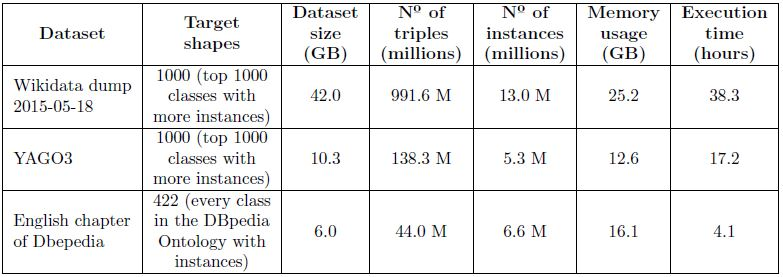



The input feature with the highest impact on memory usage is the number of instances involved.

The previous table includes a computation of the English chapter of DBpedia. In the following chart you can see how memory usage and execution time takes when you to compute a given number of instances:


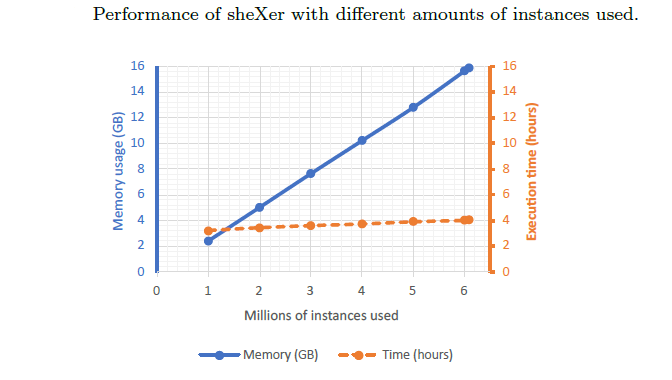

However, to get an accurate shape, normally you do not need to use every available entity, but a representative enough group of them. In the following chart, one can see how the results of the previous computation vary w.r.t. the max number of entities used to extract each shape:


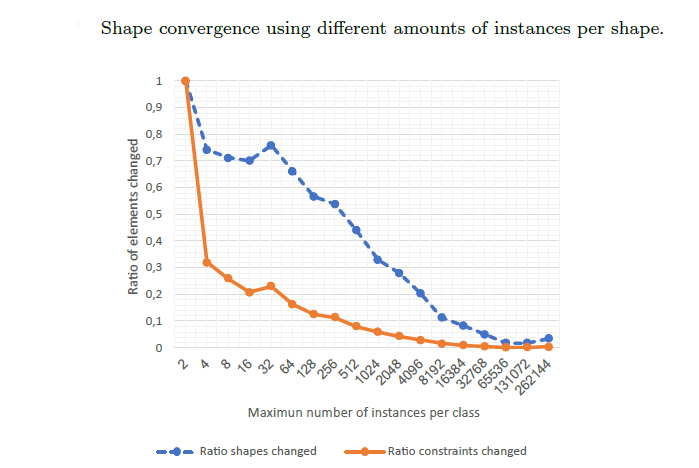